In [91]:
### Setting the environment
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt

In [86]:
### Loading data

### From ckan output
source_ckan = pd.read_csv('../data/ckan_output.csv')
source_ckan['Source'] = 'ckan'

### From google sheets
source_gsheets = pd.read_csv('../data/from_Google_Sheets.csv')
source_gsheets['Source'] = 'gsheets'

### From arcgis api
source_arcgis = pd.DataFrame()
folder = '../data/arcgis/'
for dirname, _, filenames in os.walk(folder):
    for filename in filenames:
        if filename.rsplit('.',1)[1] == 'csv':
            source_arcgis = source_arcgis.append(pd.read_csv(folder + r'/' + filename))
source_arcgis['Source'] = 'arcgis'

### all combined and output to csv
data = source_ckan.append(source_gsheets)
data = data.append(source_arcgis)
drop_list = ['Development, Safety and Regulation']
data = data[~data['Owner'].isin(drop_list)]
data['Owner'] = data['Owner'].replace('open.data@southayrshire','South Ayrshire')
data['DateUpdated'] = pd.to_datetime(data['DateUpdated'], format='%Y-%m-%d', errors='ignore')
data = data.reset_index(drop=True)
data.to_csv('../data/merged_output.csv')


data['Owner'] = data['Owner'].str.replace(' Council','')

### list of local authorities
data_localauthorities = pd.read_csv('../data/local_authorities_list.csv').rename(columns={'itemLabel':'Council'})
data_localauthorities['Council'] = data_localauthorities['Council'].str.replace(' Council','')

### distinct datasets by council
data_distinct = data[['Owner','Title','PageURL','Source']]
data_distinct = data_distinct.drop_duplicates()

### tags used in the datasets
data_tags = data[['Owner', 'PageURL','OriginalTags','ManualTags']]
data_tags = data_tags.drop_duplicates()

#data

In [45]:
print('data: ', len(data))
print('data_distinct: ', len(data_distinct))
print('data_tags: ', len(data_tags))

data:  794
data_distinct:  362
data_tags:  324


In [74]:
list(data)

['Title',
 'Owner',
 'PageURL',
 'AssetURL',
 'DateCreated',
 'DateUpdated',
 'FileSize',
 'FileSizeUnit',
 'FileType',
 'NumRecords',
 'OriginalTags',
 'ManualTags',
 'License',
 'Description',
 'Source']

In [47]:
### PLT

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# function to add value labels
def addlabels(x,y,dp):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i],dp), ha = 'center')


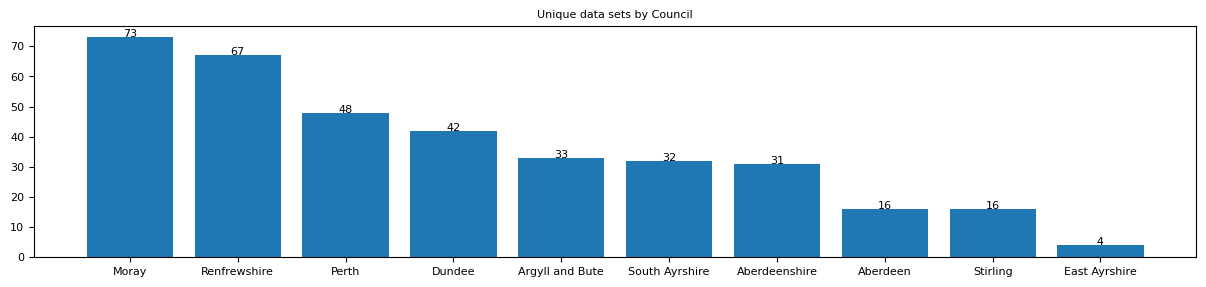

In [59]:
stats_a = data_distinct.groupby(['Owner']).size().reset_index().rename(columns={0:'Count'})
stats_a = stats_a.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(15,3))
plt.bar(x=stats_a['Owner'], height=stats_a['Count'])
plt.ylabel(''), plt.xlabel('')
#plt.xticks(rotation=90)
addlabels(stats_a['Owner'], stats_a['Count'],0)
plt.title('Unique data sets by Council')
plt.savefig('Unique data sets by Council.png')
plt.show()


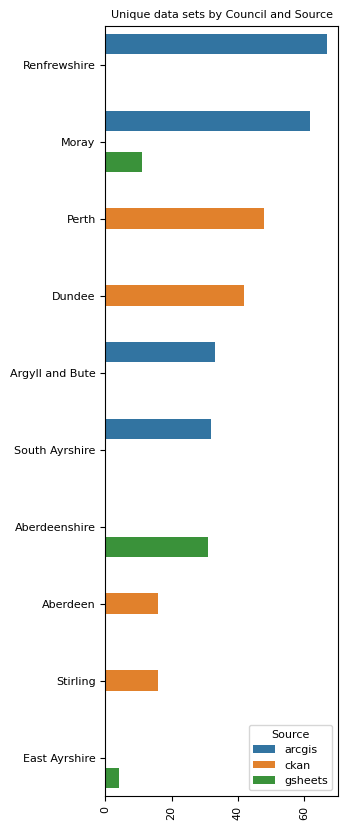

In [49]:
stats_b = data_distinct.groupby(['Owner','Source']).size().reset_index().rename(columns={0:'Count'})
stats_b = stats_b.sort_values(by=['Count'], ascending=False).reset_index(drop=True)
stats_b

plt.figure(figsize=(3,10))
#plt.bar(x=stats_a['Owner'], height=stats_a['Count'])
sns.barplot(y='Owner', x='Count', data=stats_b, hue='Source')
plt.ylabel(''), plt.xlabel('')
plt.xticks(rotation=90)
#addlabels(stats_b['Owner'], stats_b['Count'])
plt.title('Unique data sets by Council and Source')
plt.savefig('Unique data sets by Council and Source.png')
plt.show()


In [50]:
stats_b_pivot = stats_b.pivot(index='Owner',columns='Source', values='Count').reset_index()
stats_b_pivot.loc['Source_Total']= stats_b_pivot.sum(numeric_only=True, axis=0)
stats_b_pivot.loc[:,'Council_Total'] = stats_b_pivot.sum(numeric_only=True, axis=1)
stats_b_pivot

Source,Owner,arcgis,ckan,gsheets,Council_Total
0,Aberdeen,NaN,16.0,NaN,16.0
1,Aberdeenshire,NaN,NaN,31.0,31.0
2,Argyll and Bute,33.0,NaN,NaN,33.0
3,Dundee,NaN,42.0,NaN,42.0
4,East Ayrshire,NaN,NaN,4.0,4.0
5,Moray,62.0,NaN,11.0,73.0
6,Perth,NaN,48.0,NaN,48.0
7,Renfrewshire,67.0,NaN,NaN,67.0
8,South Ayrshire,32.0,NaN,NaN,32.0
9,Stirling,NaN,16.0,NaN,16.0


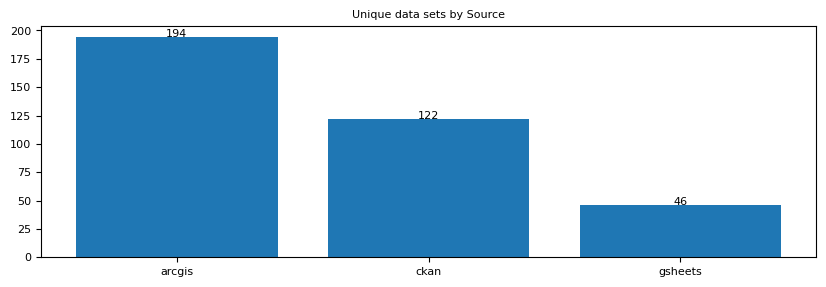

In [51]:
stats_b1 = data_distinct.groupby(['Source']).size().reset_index().rename(columns={0:'Count'})
stats_b1 = stats_b1.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,3))
plt.bar(x=stats_b1['Source'], height=stats_b1['Count'])
plt.ylabel(''), plt.xlabel('')
addlabels(stats_b1['Source'], stats_b1['Count'],0)
plt.title('Unique data sets by Source')
plt.savefig('Unique data sets by Source.png')
plt.show()


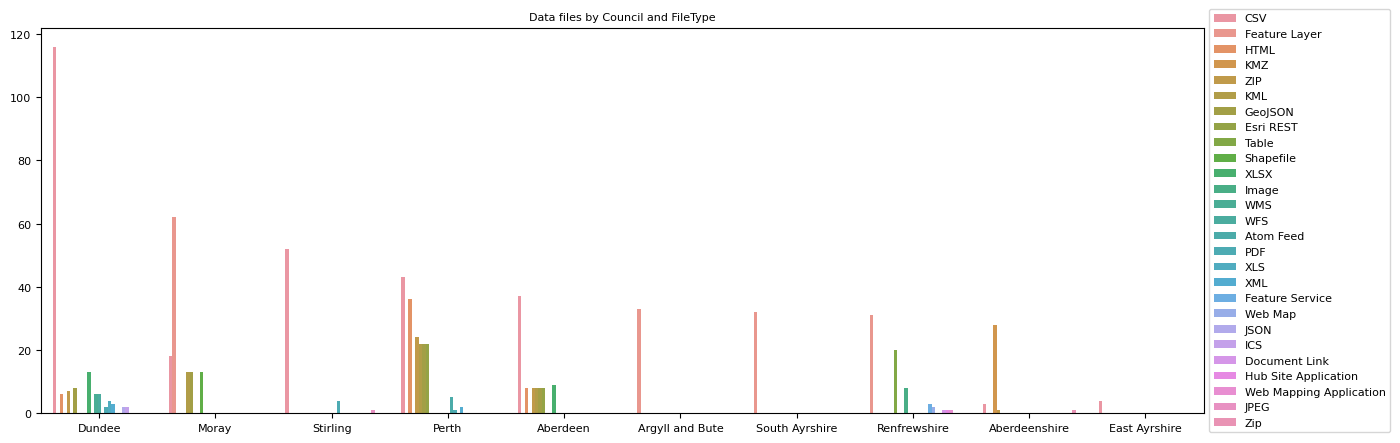

In [60]:
stats_c = data.groupby(['Owner','FileType']).size().reset_index().rename(columns={0:'Count'})
stats_c = stats_c.sort_values(by=['Count'], ascending=False).reset_index(drop=True)
stats_c

plt.figure(figsize=(15,5))
#plt.bar(x=stats_a['Owner'], height=stats_a['Count'])
sns.barplot(x='Owner', y='Count', data=stats_c, hue='FileType')
plt.ylabel(''), plt.xlabel('')
#plt.xticks(rotation=90)
#addlabels(stats_c['Owner'], stats_c['Count'])
plt.title('Data files by Council and FileType')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Data files by Council and FileType.png')
plt.show()


In [53]:
stats_c_pivot = stats_c.pivot(index='Owner',columns='FileType', values='Count').reset_index()
stats_c_pivot.loc['FileType_Total']= stats_c_pivot.sum(numeric_only=True, axis=0)
stats_c_pivot.loc[:,'Council_Total'] = stats_c_pivot.sum(numeric_only=True, axis=1)
stats_c_pivot

FileType,Owner,Atom Feed,CSV,Document Link,Esri REST,Feature Layer,Feature Service,GeoJSON,HTML,Hub Site Application,...,WFS,WMS,Web Map,Web Mapping Application,XLS,XLSX,XML,ZIP,Zip,Council_Total
0,Aberdeen,NaN,37.0,NaN,8.0,NaN,NaN,8.0,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,9.0,NaN,8.0,NaN,86.0
1,Aberdeenshire,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,33.0
2,Argyll and Bute,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0
3,Dundee,NaN,116.0,NaN,NaN,NaN,NaN,8.0,6.0,NaN,...,6.0,6.0,NaN,NaN,4.0,13.0,3.0,7.0,NaN,175.0
4,East Ayrshire,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
5,Moray,NaN,18.0,NaN,NaN,62.0,NaN,13.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0
6,Perth,5.0,43.0,NaN,22.0,NaN,NaN,22.0,36.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,24.0,NaN,177.0
7,Renfrewshire,NaN,NaN,1.0,NaN,31.0,3.0,NaN,NaN,1.0,...,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,67.0
8,South Ayrshire,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0
9,Stirling,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0


In [54]:
data_tags['AllTags'] = data_tags.apply(lambda x: str(x['OriginalTags'])+ ';' + str(x['ManualTags']), axis=1)
data_tags['AllTags_Tuple'] = data_tags['AllTags'].str.split(';')

stats_d = data_tags[['Owner','AllTags_Tuple']]
'''
plt.figure(figsize=(10,3))
sns.barplot(x='Owner', y='Count', data=stats_c, hue='FileType')
plt.ylabel(''), plt.xlabel('')
#addlabels(stats_c['Owner'], stats_c['Count'])
plt.title('Unique data sets by Council and FileType')
plt.legend(loc='upper right')
plt.show()
'''
stats_d

,Owner,AllTags_Tuple
0,Aberdeen,"[Aberdeen, Contracts, Finance, nan]"
1,Aberdeen,"[Aberdeen, Military, nan]"
12,Aberdeen,"[Academy Catchments, Academy Zones, Boundaries..."
18,Aberdeen,"[Air Quality, Environment, Health, Nitrogen Di..."
24,Aberdeen,"[Aberdeen, Art Gallery, Design, Fashion, Museu..."
...,...,...
62,Renfrewshire,"[Open Data Platform, nan]"
63,Renfrewshire,"[Open Data, Renfrewshire, nan]"
64,Renfrewshire,"[paisley is, nan]"
65,Renfrewshire,"[Open Data, Renfrewshire, nan]"


No handles with labels found to put in legend.


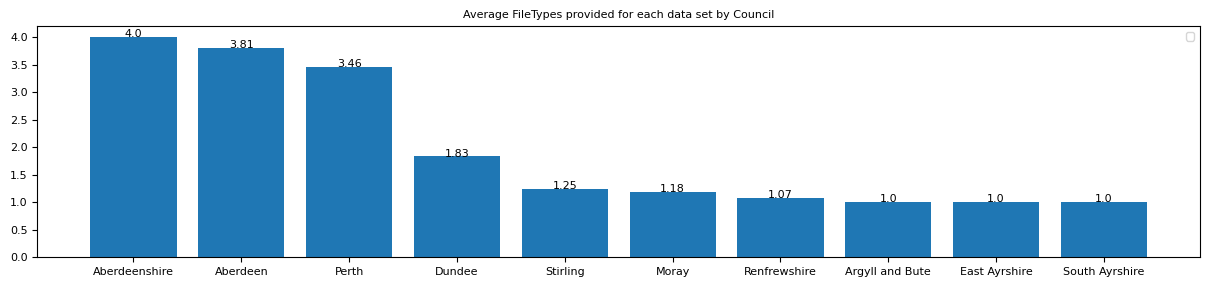

In [62]:
stats_e = data.groupby(['Owner','PageURL'])['FileType'].nunique().reset_index()
stats_e = stats_e.groupby(['Owner'])['FileType'].mean().reset_index()
stats_e = stats_e.sort_values(by=['FileType'], ascending=False).reset_index(drop=True)
stats_e

plt.figure(figsize=(15,3))
plt.bar(x=stats_e['Owner'], height=stats_e['FileType'])
plt.ylabel(''), plt.xlabel('')
#plt.xticks(rotation=90)
addlabels(stats_e['Owner'], stats_e['FileType'],2)
plt.title('Average FileTypes provided for each data set by Council')
plt.legend(loc='upper right')
plt.savefig('Average FileTypes provided for each data set by Council.png')
plt.show()

# Scorecard

- Has an open data portal/site
- Has content on the site
- Data has been published within (the last 1 year, 6 months, 90 days, 30 days)
- rank of # filetypes offered
- rank of combined data size

In [87]:
data['DateUpdated'][0]

Timestamp('2020-03-23 00:00:00')

In [96]:
# Calculating scores
# Has an OD site
la_withod = set(data['Owner'])

# Last updated
last_update = data.groupby(['Owner'])['DateUpdated'].max().reset_index()
today = dt.datetime.today()
last_update['Days_Passed'] = last_update['DateUpdated'].apply(lambda x: (today - x).days)
#last_365days = [c for c in last_update['Owner'] if last_update ]
last_update['in365'] = last_update['Days_Passed'] < 365
last_update['in180'] = last_update['Days_Passed'] < 180
last_update['in90'] = last_update['Days_Passed'] < 90
last_update['in60'] = last_update['Days_Passed'] < 60
last_update




,Owner,DateUpdated,Days_Passed,in365,in180,in90,in60
0,Aberdeen,2020-08-03,314.0,True,False,False,False
1,Aberdeenshire,2021-05-20,24.0,True,True,True,True
2,Argyll and Bute,2021-06-08,5.0,True,True,True,True
3,Dundee,2019-01-29,866.0,False,False,False,False
4,East Ayrshire,NaT,NaN,False,False,False,False
5,Moray,2021-06-12,1.0,True,True,True,True
6,Perth,2019-09-10,642.0,False,False,False,False
7,Renfrewshire,2021-04-30,44.0,True,True,True,True
8,South Ayrshire,2021-03-24,81.0,True,True,True,False
9,Stirling,2021-04-30,44.0,True,True,True,True


In [103]:
scorecard = data_localauthorities.copy()
scorecard['Has OD Site'] = scorecard['Council'].isin(la_withod)
scorecard = scorecard.merge(last_update, how='left', left_on='Council', right_on='Owner')
scorecard = scorecard.drop(columns=['DateUpdated','Owner','Days_Passed'])
scorecard = scorecard.fillna(0)
scorecard = scorecard.replace(True, 1)
scorecard = scorecard.replace(False, 0)
scorecard.loc['Score_Total']= scorecard.sum(numeric_only=True, axis=0)
scorecard.loc[:,'Area_Total'] = scorecard.sum(numeric_only=True, axis=1)
scorecard

,Council,Has OD Site,in365,in180,in90,in60,Area_Total
0,Aberdeen City,0.0,0.0,0.0,0.0,0.0,0.0
1,Aberdeenshire,1.0,1.0,1.0,1.0,1.0,5.0
2,Angus,0.0,0.0,0.0,0.0,0.0,0.0
3,Argyll and Bute,1.0,1.0,1.0,1.0,1.0,5.0
4,City of Edinburgh,0.0,0.0,0.0,0.0,0.0,0.0
5,Clackmannanshire,0.0,0.0,0.0,0.0,0.0,0.0
6,Comhairle nan Eilean Siar,0.0,0.0,0.0,0.0,0.0,0.0
7,Dumfries and Galloway,0.0,0.0,0.0,0.0,0.0,0.0
8,Dundee City,0.0,0.0,0.0,0.0,0.0,0.0
9,East Ayrshire,1.0,0.0,0.0,0.0,0.0,1.0
